#  **Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# **Loading the Dataset**

In [ ]:
dataset_path = "/content/drive/MyDrive/plant-pathology-2020-fgvc7"   # https://drive.google.com/drive/folders/1DzqCsDAqHpf5hM-LjmDykjces8JFwQjY?usp=sharing
image_dir = os.path.join(dataset_path, "images")
csv_path = os.path.join(dataset_path, "train.csv")

In [ ]:
df=pd.read_csv(csv_path)
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
# Full Image path
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x + ".jpg"))

In [ ]:
df['image_path']

,image_path
0,/content/drive/MyDrive/plant-pathology-2020-fg...
1,/content/drive/MyDrive/plant-pathology-2020-fg...
2,/content/drive/MyDrive/plant-pathology-2020-fg...
3,/content/drive/MyDrive/plant-pathology-2020-fg...
4,/content/drive/MyDrive/plant-pathology-2020-fg...
...,...
1816,/content/drive/MyDrive/plant-pathology-2020-fg...
1817,/content/drive/MyDrive/plant-pathology-2020-fg...
1818,/content/drive/MyDrive/plant-pathology-2020-fg...
1819,/content/drive/MyDrive/plant-pathology-2020-fg...


# **Displaying a Sample Image**

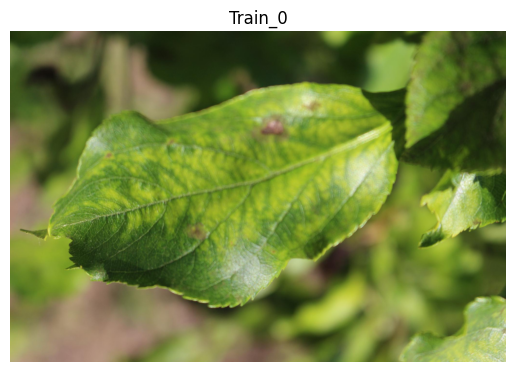

In [ ]:
img=cv2.imread(df['image_path'][0])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title(df['image_id'][0])
plt.show()

# **Extract labels from Dataset**

In [ ]:
df['label']=df[['healthy','multiple_diseases','rust','scab']].idxmax(axis=1)
df.head()

,image_id,healthy,multiple_diseases,rust,scab,image_path,label
0,Train_0,0,0,0,1,/content/drive/MyDrive/plant-pathology-2020-fg...,scab
1,Train_1,0,1,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...,multiple_diseases
2,Train_2,1,0,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...,healthy
3,Train_3,0,0,1,0,/content/drive/MyDrive/plant-pathology-2020-fg...,rust
4,Train_4,1,0,0,0,/content/drive/MyDrive/plant-pathology-2020-fg...,healthy


# **Load and Resizing Images**

In [ ]:
# Store resized images and labels
images=[]
labels=[]

# resize size
target_size=(128,128)

for i,row in df.iterrows():
  img=cv2.imread(row['image_path'])
  label=row['label']
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,target_size)

  images.append(img)
  labels.append(label)

# **Histogram-Based Feature Extraction**

In [ ]:
def extract_color_histogram(image,bins=(8,8,8)):
  hsv=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
  hist=cv2.calcHist([hsv],[0,1,2],None,bins,[0,256,0,256,0,256])
  cv2.normalize(hist,hist)
  return hist.flatten()

# Apply to all images
histograms=[]
for img in images:
  hist=extract_color_histogram(img)
  histograms.append(hist)

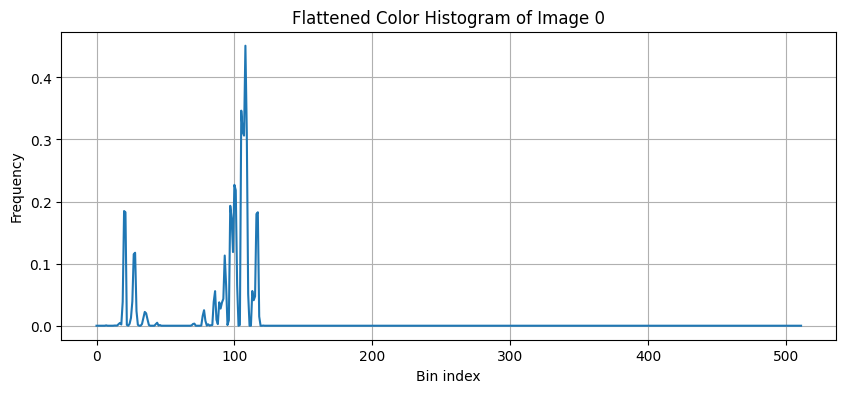

In [ ]:
import matplotlib.pyplot as plt

# visualizing the first image's histogram
plt.figure(figsize=(10, 4))
plt.plot(histograms[0])
plt.title("Flattened Color Histogram of Image 0")
plt.xlabel("Bin index")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# **Visualizing Sample Images and Histograms**

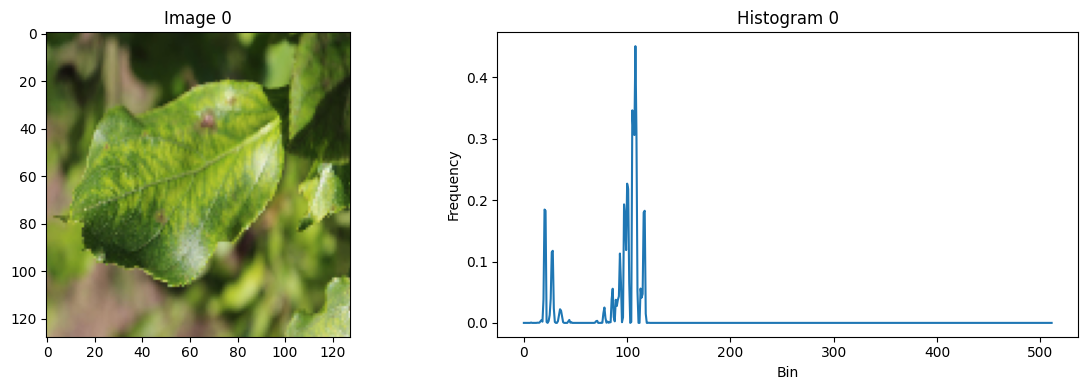

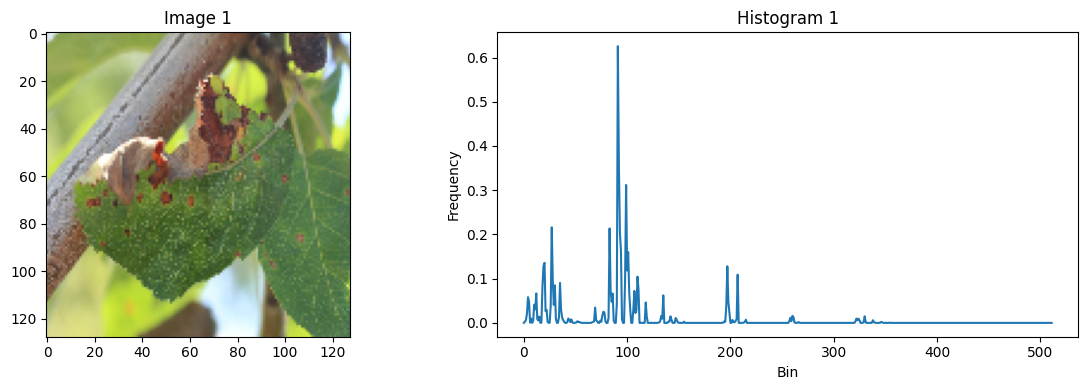

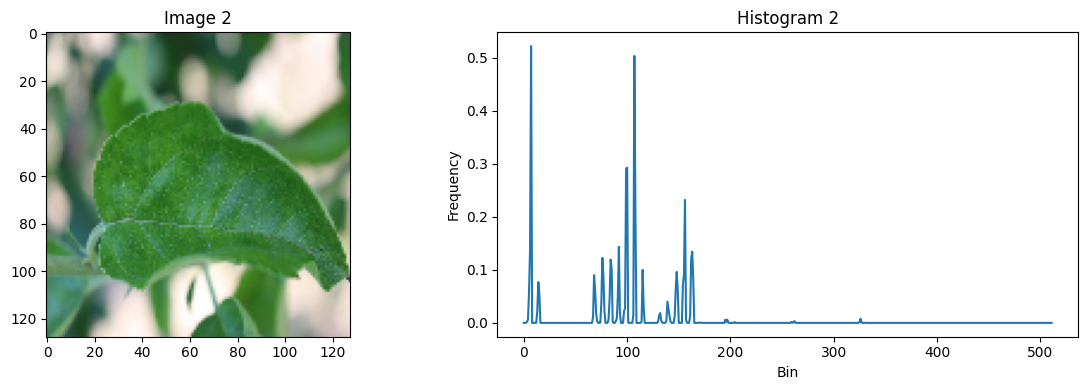

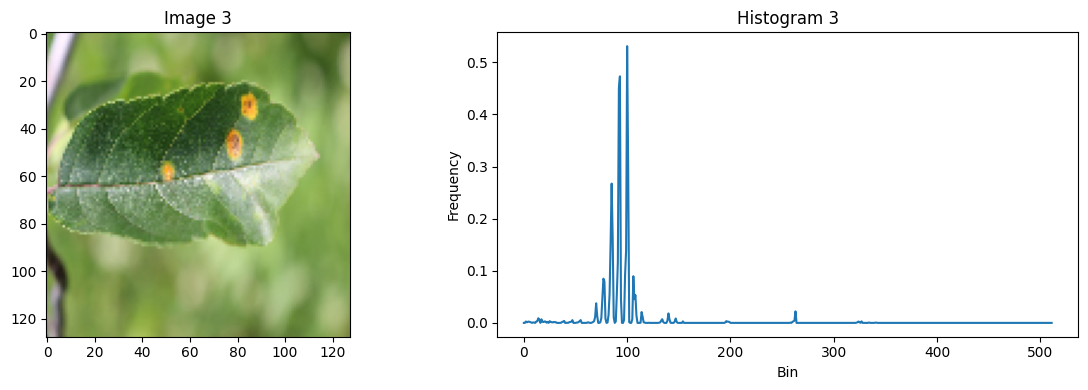

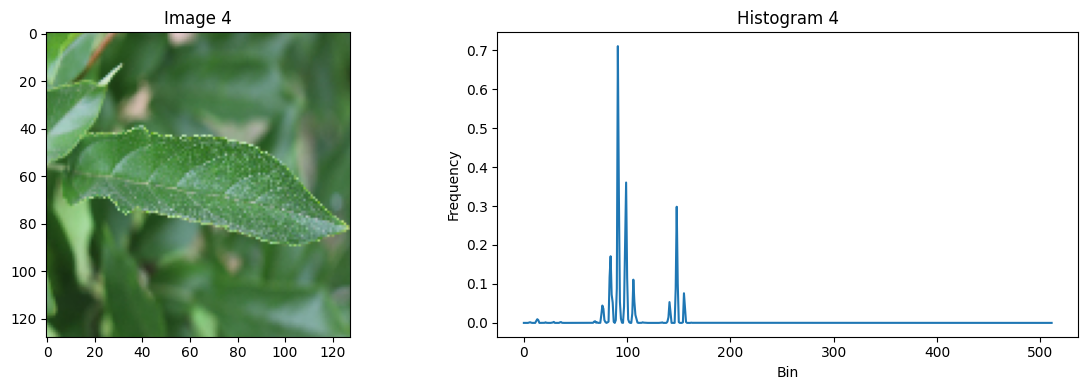

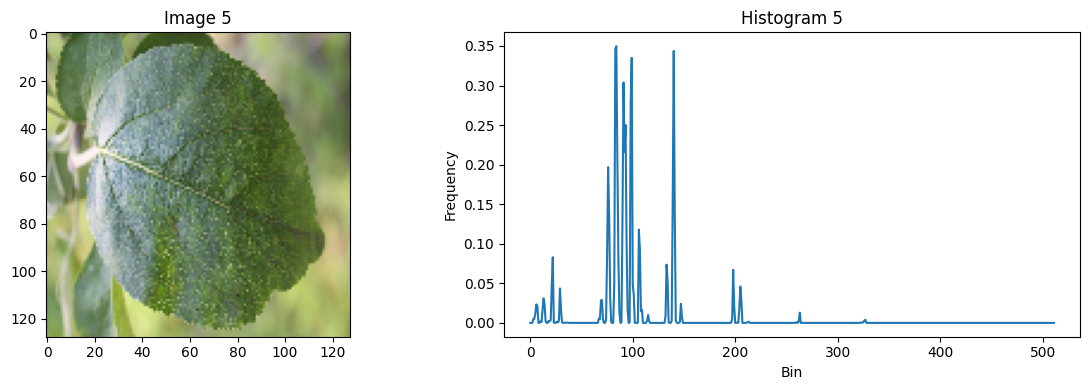

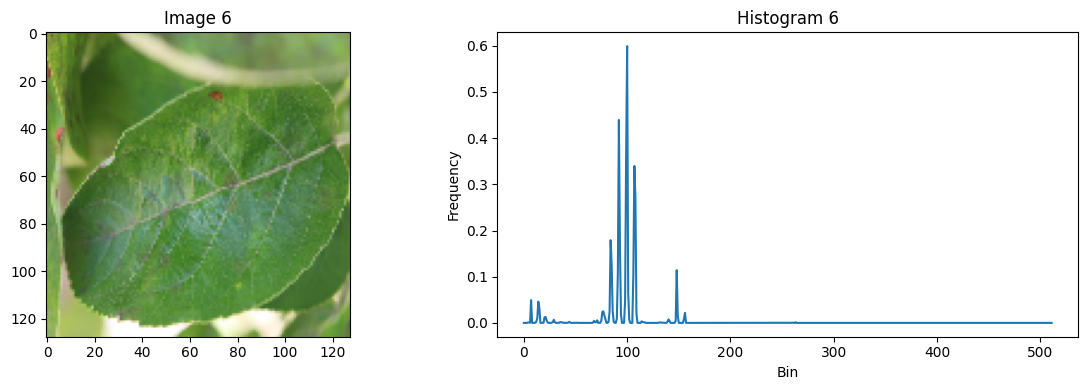

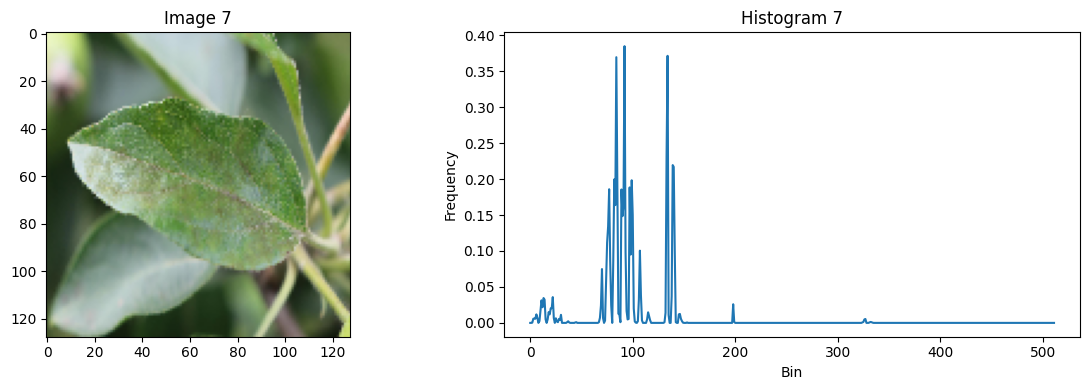

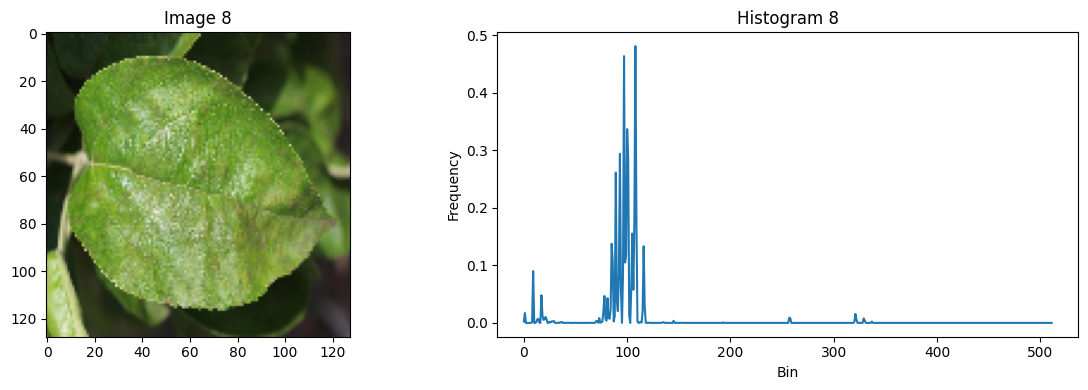

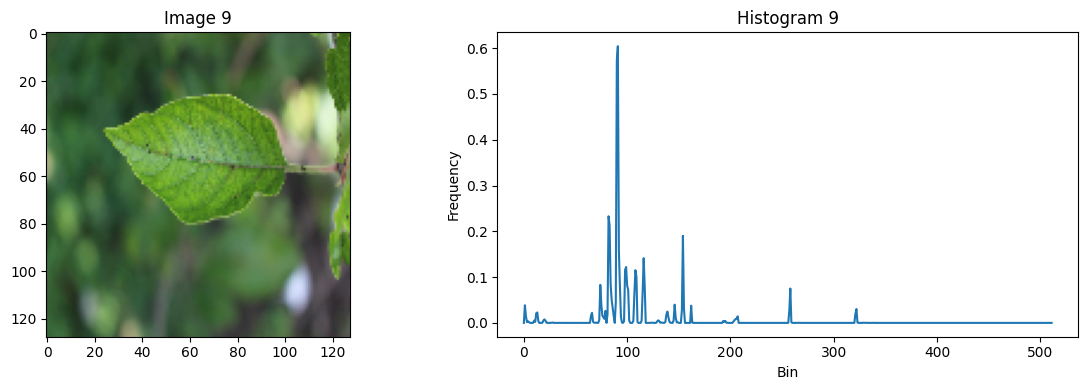

In [ ]:
# visualizing the first 10 images and histograms

for i in range(10):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title(f"Image {i}")

    plt.subplot(1, 2, 2)
    plt.plot(histograms[i])
    plt.title(f"Histogram {i}")
    plt.xlabel("Bin")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# **Data Preprocessing and Splitting**




In [ ]:
X=np.array(histograms)
y=np.array(labels)

In [ ]:
# Feature Scaling

from sklearn.preprocessing import LabelEncoder,StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)
le=LabelEncoder()
y_encoded=le.fit_transform(y)

In [ ]:
# Splitting into Train and Test data

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42)

# Training: **Support Vector Machine (SVM)**

#### **Hyperparameter Tuning using GridSearchCV**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto']}
svc_for_grid = SVC()
grid_search = GridSearchCV(estimator=svc_for_grid, param_grid=parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [ ]:
best_model1=grid_search.best_estimator_
best_model1

In [ ]:
print("Best SVC model Accuracy: ",best_model1.score(X_test,y_test))
print("Best SVC Model Hyperparameters: ",best_model1.get_params())

In [ ]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model1, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())

#### **Hyperparameter tuning with RandomizedSearchCV**


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
parameter={'C':uniform(0.1,10),
            'kernel':['linear','rbf','poly'],
            'gamma':['scale','auto']+list(np.logspace(-3,3,50))}
svc_for_random=SVC()
randomized_search=RandomizedSearchCV(estimator=svc_for_random,
                                      param_distributions=parameters,
                                      cv=5)

In [ ]:
randomized_search.fit(X_train,y_train)

In [ ]:
best_model=randomized_search.best_estimator_
best_model

In [ ]:
print("Best SVM accuracy: ",best_model.score(X_test,y_test))
print("Best Hyperparameters: ",best_model.get_params())

In [ ]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())

Cross-validation accuracy: [0.60958904 0.63573883 0.64604811 0.64261168 0.65635739]
Average accuracy: 0.6380690109683189


#### **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, best_model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()
plt.show()

# Training: **Random Forest Classifier**

####  **Hyperparameter tuning with GridSearchCV**



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}
classifier=RandomForestClassifier()
grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
best_model3=grid_search.best_estimator_
best_model3

In [ ]:
print("Best Accuracy: ",best_model3.score(X_test,y_test))
print("Best Hyperparameters: ",best_model3.get_params())

In [ ]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model3, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())


#### **Hyperparameter tuning with RandomizedSearchCV**


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=200)


In [ ]:
best_model4=random_search.best_estimator_
best_model4

In [ ]:
print("Best Accuracy: ",best_model4.score(X_test,y_test))
print("Best Hyperparameters: ",best_model4.get_params())

In [ ]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model3, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())


#### **Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()


# Training: **Gradient Boost Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
classifier2=GradientBoostingClassifier()
classifier2.fit(X_train,y_train)

In [ ]:
classifier2.score(X_test,y_test)

#### **Hyperparameter tuning with RandomizedSearchCV**


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)


In [ ]:
best_model5=random_search.best_estimator_
best_model5

In [ ]:
print("Best Accuracy: ",best_model5.score(X_test,y_test))
print("Best Hyperparameters: ",best_model5.get_params())

In [ ]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model5, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())

Cross-validation accuracy: [0.73630137 0.78006873 0.78350515 0.76975945 0.79725086]
Average accuracy: 0.7733771124605753


#### **Confusion Matrix**

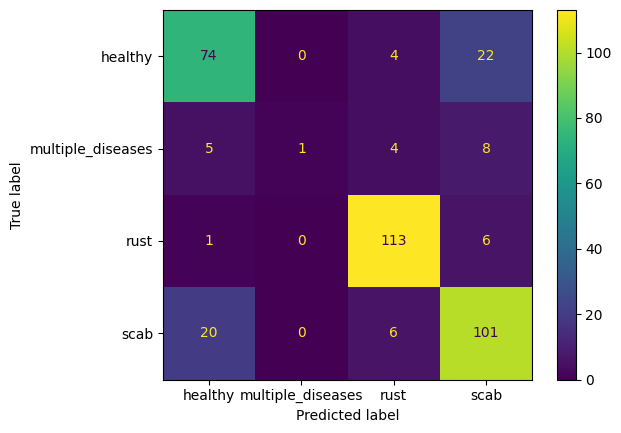

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model5.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

# Training: **XGBoost Classifier**

#### **Hyperparameter tuning with RandomizedSearchCV**


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,                  # Increase for better tuning
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [43]:
model = random_search.best_estimator_
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
model.score(X_test,y_test)

0.7972602739726027

In [45]:
print(" Best XGBoost Model Accuracy:", model.score(X_test, y_test))
print(" Best Hyperparameters:", model.get_params())

 Best XGBoost Model Accuracy: 0.7972602739726027
 Best Hyperparameters: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


#### **Confusion Matrix**

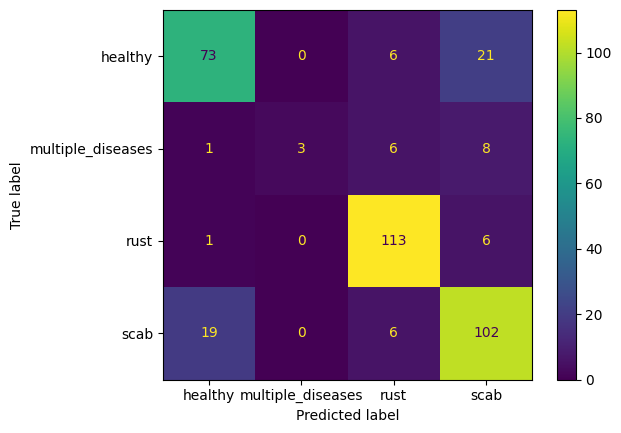

In [46]:
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

In [47]:
# Cross Validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation accuracy:", scores)
print("Average accuracy:", scores.mean())


Cross-validation accuracy: [0.72945205 0.78694158 0.78350515 0.78006873 0.82817869]
Average accuracy: 0.7816292425740243


# **Model Performance Comparison**



 Final Model Accuracy Comparison:

             Model Test Accuracy
     Random Forest        80.82%
           XGBoost        79.73%
 Gradient Boosting        79.18%
SVM (GridSearchCV)        64.93%


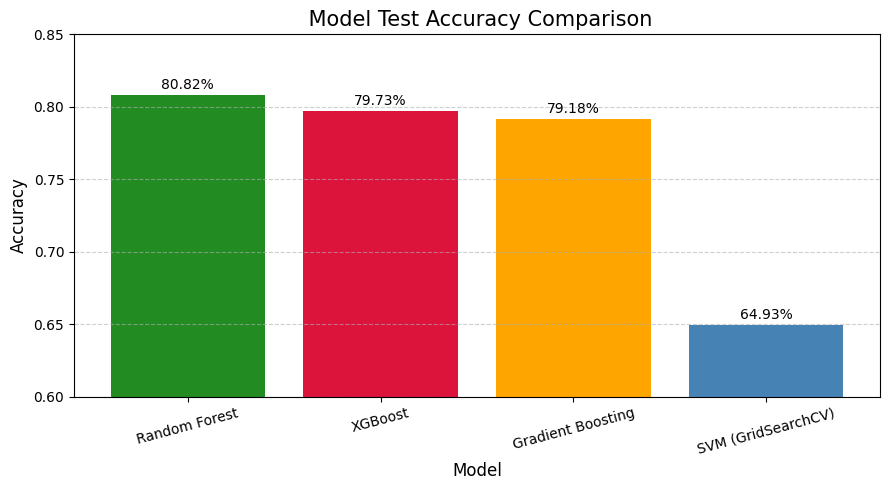

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Final test accuracies of models
accuracy_results = {
    "SVM (GridSearchCV)": 0.6493150684931507,
    "Random Forest": 0.8082191780821918,
    "Gradient Boosting": 0.7917808219178082,
    "XGBoost": 0.7972602739726027
}

# Create and sort DataFrame
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=["Model", "Test Accuracy"])
accuracy_df.sort_values(by="Test Accuracy", ascending=False, inplace=True)

# Print accuracy table
print("\n Final Model Accuracy Comparison:\n")
accuracy_df_display = accuracy_df.copy()
accuracy_df_display["Test Accuracy"] = (accuracy_df_display["Test Accuracy"] * 100).map("{:.2f}%".format)
print(accuracy_df_display.to_string(index=False))

# Plot bar chart
plt.figure(figsize=(9, 5))
bars = plt.bar(accuracy_df["Model"], accuracy_df["Test Accuracy"], color=['forestgreen', 'crimson', 'orange', 'steelblue'])
plt.title(" Model Test Accuracy Comparison", fontsize=15)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.6, 0.85)

# Annotate bars with accuracy %
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f"{height*100:.2f}%", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# **Classification Report Analysis**

In [49]:
from sklearn.metrics import classification_report

models = {
    "SVM (GridSearchCV)": best_model1,
    "Random Forest": best_model4,
    "Gradient Boosting": best_model5,
    "XGBoost": model
}

# Evaluate each model
for name, model in models.items():
    print(f"\n📋 Classification Report for {name}:\n")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab'],zero_division=0))



📋 Classification Report for SVM (GridSearchCV):

                   precision    recall  f1-score   support

          healthy       0.53      0.68      0.60       100
multiple_diseases       0.40      0.11      0.17        18
             rust       0.79      0.74      0.77       120
             scab       0.65      0.61      0.63       127

         accuracy                           0.65       365
        macro avg       0.59      0.54      0.54       365
     weighted avg       0.65      0.65      0.64       365


📋 Classification Report for Random Forest:

                   precision    recall  f1-score   support

          healthy       0.76      0.71      0.74       100
multiple_diseases       0.00      0.00      0.00        18
             rust       0.84      0.95      0.89       120
             scab       0.74      0.79      0.76       127

         accuracy                           0.78       365
        macro avg       0.58      0.61      0.60       365
     weighted a

# **Final Model Selection**
The **Random Forest classifier** has been selected for deployment due to its:

1. Highest overall accuracy (80%)

2. Strong weighted F1-score (0.78) across all classes

3. Reliable performance on major disease categories

4. Balanced and interpretable behavior, making it ideal for real-world use

Although rare class detection remains challenging, Random Forest offers the most consistent and robust results overall.







In [50]:
random_forest_model = RandomForestClassifier(bootstrap=False, min_samples_leaf=2)
random_forest_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2)

# **Saving and Downloading the Trained Model**

In [51]:
import joblib
joblib.dump(random_forest_model,'final_model.pkl')

['final_model.pkl']

In [52]:
from google.colab import files
files.download('final_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>